# Time Series 


### Basic

시간에 따른 일련의 데이터를 Time series data라고 합니다. <br>
단 한개의 변수로 이루어진 time series를 **univariate** 이라고 하며, 2개 이상의 변수로 이루어진 time series를 **multivariate**이라고 합니다.


### Trend, Cyclical, Seasonal, Irregular 

Time series는 일반적으로 4개의 요소 (Trend, Cyclical, Seasonal 그리고 Irregular)에 의해 영향을 받습니다.

| Name | Description |
|:-----|:------------|
| **Trend(추세)** |  장기적인 관점에서 봤을때 그래프가 증가하는지, 감소하는지, 또는 정체되어 있는지등의 추세를 Trend라고 합니다.<br>Trend는 따라서 time series안에서 long term movement를 보는 것이 중요합니다. |
| **Seasonality(계절성)** | 특정 구간동안의 (1년, 한달, 일주일..) 변동성(fluctuations)를 나타냅니다. <br>예를 들어서 아이스크림 판매량은 여름에 늘어나고, 외투는 겨운에 판매량이 늘어날 것입니다. 또는 피트니스센터의 고객은 매년 결심을 하는 1월 초에 가장많은 사람들이 나올것입니다. 하지만 매월초가 될수도 있고, 매주초가 될 수도 있습니다. 따라서 피트니스센터는 년, 월, 주단위 seasonality를 갖고 있다고 할수 있습니다. |
| **Cycle(주기)** | Seasonality는 특정 기간에 정확하게 나타나는 변동성을 갖고 있는 반면, Cycle의 경우 특정 시간에 구애 받지 않습니다. 하지만 동일하게 특정 패턴을 갖고 있습니다. 보통 2~3년처럼 장기간에 걸친 패턴을 갖고 있을수 있습니다. 예를 들어서 business cycle의 경우에는 호황 -> 불황 -> 침체 -> 회복 의 cycle을 갖고 있습니다. | 
| **Irregularity(불규칙성)** | 또는 random variations이라고 불리며 예상치 못한 영향에 의해서 나타납니다. 예를 들어서 전쟁, 지진, 홍수, 혁명등등이 될 수 있습니다. |



# Import

In [40]:
%pylab inline
import pandas as pd
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score

Populating the interactive namespace from numpy and matplotlib


# Data

아래의 링크에서 데이터를 다운받을 수 있습니다.<br>
[Daily minimum temperatures in Melbourne, Australia, 1981-1990](https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line)

[Header]
Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64

Train Size: (2550, 1)
Test Size : (1100, 1)


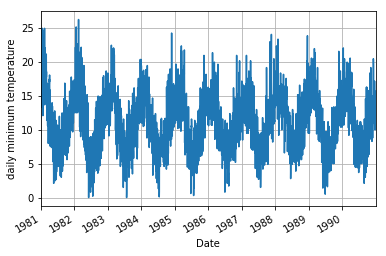

In [44]:
TEST_SIZE = 1100

_filename= '/dataset/daily-minimum-temperature-in-melbourne/daily-minimum-temperatures-in-me.csv'
dataframe = pd.Series.from_csv(_filename, header=0)
dataframe.index = dataframe.index.to_datetime()
dataframe = dataframe.astype('float64')
print('[Header]')
print(dataframe.head())
dataframe.plot(grid=True)
ylabel('daily minimum temperature')

# Normalization 
scaler = MinMaxScaler()
data = scaler.fit_transform(dataframe.values.reshape((-1, 1)))

# Split Training and Test Data
train, test = data[:-TEST_SIZE], data[-TEST_SIZE:]
# train, test = train_test_split(data, test_size=0.1)
# train_data, test_data = data[0:len(data)-7], data[len(data)-7:]
print()
print('Train Size:', train.shape)
print('Test Size :', test.shape)

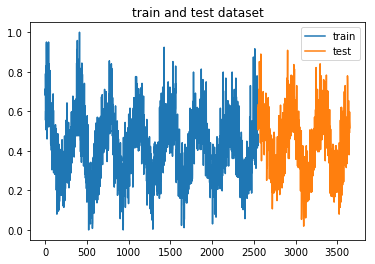

In [5]:
plot(np.arange(len(train)), train, label='train')
plot(np.arange(len(train), len(train)+len(test)), test, label='test')
legend()
title('train and test dataset')

# Autocorrelation Checking

Autoregression은 이전의 time-steps의 observations을 통해 다음 step의 값을 예측하는데 사용될 수 있다는 가정을 갖고 있습니다.<br>
variables관의 관계를 correlation이라고 하며, 두 variables이 동시에 증가하거나 감소하면 **positive correlation**이라고 하며, 서로 반대방향으로 움직인다면 (하나는 증가하고, 하나는 감소하는 상황.) **negative correlation**이라고 합니다.

output variable (예측값) 그리고 이전 time-steps의 값(lagged variables)들의 correlation을 구함으로서 통계적 측정을 할 수 있습니다.<br>
correlation을 통해서 얼마만큼의 lag variables을 사용해야될지 알 수 있으며, 그래프가 predictable한지 안 한지도 알 수 있습니다.

> Autocorrelation에서 auto가 붙는 이유는 위에서 설명했듯이, 자기자신(auto or self)의 데이터를 사용하여 자기 자신의 데이터를 예측하기 때문에 이렇게 이름이 지어졌습니다.



### Lag Plot 

빠르게 correlation이 존재하는지 확인하는 방법은 step t 와 t-1 을 scatter plot으로 그래서 확인하는 방법입니다.<br>
집접 데이터를 가공해서 만들수도 있지만, Pandas에서는 lag_plot이라는 함수를 통해서 쉽게 lag plot을 그려볼 수 있습니다.


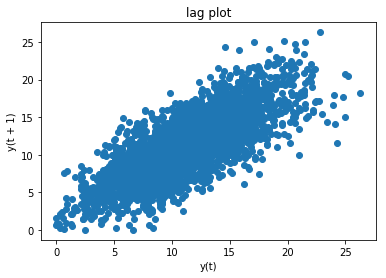

In [6]:
lag_plot(dataframe, lag=1)
title('lag plot')

step t 와 step t-1 의 관계가 전혀 없는 random한 상황속에서는 다음과 같이 그래프가 그려집니다.

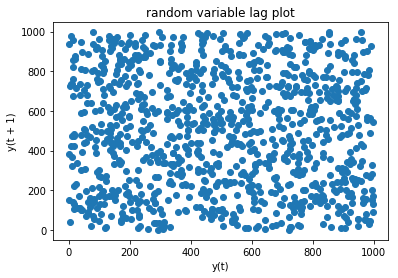

In [7]:
series = pd.Series([np.random.randint(0, 1000) for _ in range(1000)])
lag_plot(series)
title('random variable lag plot')

### Pearson Correlation Coefficient

t-1 과 t의 상관관계를 pearson correlation으로 구할수 있습니다. <br>

* negative correlated: -1 
* positive correlated: 1
* correlation: 0.5보다 크거나, -0.5보다 작을시 높은 correlation

아래의 예제에서는 0.77487의 correlation값을 보이는데 positive correlated이며 correlation이 높다고 할 수 있습니다.

In [8]:
data2 = pd.concat([dataframe.shift(2), dataframe.shift(1), dataframe], axis=1)
data2.columns = ['t-2', 't-1', 't']
data2.corr()

,t-2,t-1,t
t-2,1.000000,0.774886,0.631119
t-1,0.774886,1.000000,0.774870
t,0.631119,0.774870,1.000000


### Autocorrelation Plot

각각의 lag variable에 대한 correlation을 plotting할 수 도 있지만, Pandas에서 이미 지원해주고 있습니다.

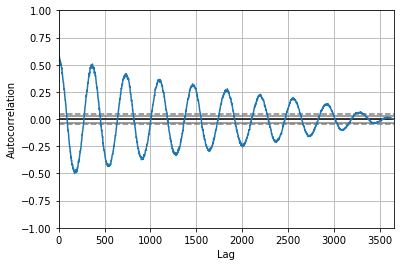

In [10]:
autocorrelation_plot(data)

statsmodel 라이브러리에서 제공하는 plot_acf를 사용할수도 있습니다.

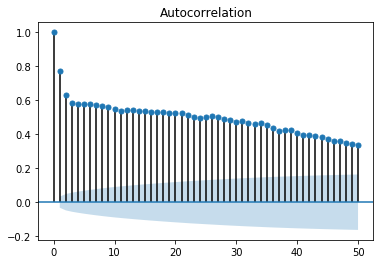

In [11]:
plot_acf(data, lags=50)
print(end='')

Random variable의 경우에는 다음과 같이 전혀 맞지 않게 나옵니다.

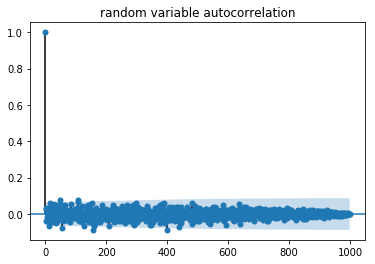

In [12]:
series = pd.Series([np.random.randint(0, 1000) for _ in range(1000)])
plot_acf(series, title='random variable autocorrelation')
print()

# AR (Autoregressive) Model

AR(p) (AutoRegressive of order p)는 간단하게 과거의 패턴이 지속된다면 <br>
시계열 데이터 관측치 $ y_t $ 는 과거 관측치 $ y_{t-1} $, $ y_{t-2} $, $ y_{t-3} $, ... 에 의해 예측될 수 있다고 봅니다. <br>
오직 과거의 데이터(lagged variables)만 사용해서 예측 모형을 만들게 되며, 이름도 autoregressive 입니다. (그리스어로 auto 라는 뜻은 "self"를 가르킵니다.)<br>



$$ \begin{align}
X_t &= \alpha_1 X_{t-1} + ... + \alpha_p X_{t-p} + \epsilon_t + c  \\
&= c + \sum^p_{i=1} \alpha_i X_{t-i} + \epsilon_t
\end{align}$$ 

* **order:** $ p $
* **parameters (coefficients):** $ \alpha_1 $, $ \alpha_2 $, ..., $ \alpha_p $
* **error term (white noise):** $ \epsilon_t $


## Code Example

statsmodel에서 제공하는 AR 을 사용하면 Autoregressive Model을 구현할 수 있습니다.<br>
문제는 해당 라이브러리가 학습된 부분에서 예측을 하면 잘되나, forecast를 하려고 하면 잘 나오지를 않습니다. <br>
이는 라이브러리가 학습했었던 데이터 자체를 갖고 있고, 이것을 토대로 하여 예측을 하기 때문에, 학습 데이터의 범위를 넘어서 예측을 하려고 하면 잘 되지를 않습니다. 

Lag: 27
Params: [  2.25269603e-02   5.84961205e-01  -9.35861948e-02   4.87275788e-02
   4.87175215e-02   3.31458245e-02   2.34930490e-02   4.07033904e-02
   2.10207802e-02   3.24386773e-02  -5.58998074e-04   1.50962870e-03
   2.15314267e-02   2.89735236e-03   2.76798867e-02  -1.10002104e-03
   2.01611383e-02   5.84416099e-03   3.49395067e-02   1.57831942e-02
   2.09129893e-02   6.88643120e-03   1.34907708e-02  -2.92181040e-02
   6.81128154e-04   2.29722079e-02   1.54827053e-02   2.51074688e-02]
R^2 Score: -0.0273533184965


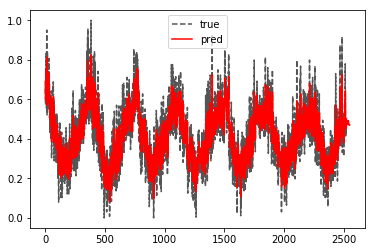

In [50]:
PRED_N = 300
model = AR(train)
model = model.fit(disp=True)

pred = model.predict(start=model.k_ar, end=len(train)+model.k_ar-1)
plot(train[model.k_ar:], linestyle="--", label='true', color="#555555")
plot(pred, label='pred', color='red')
legend()

print('Lag:', model.k_ar)
print('Params:', model.params)
print('R^2 Score:', r2_score(pred, train))

! 학습된 데이터의 범위를 넘어서 forecast를 하려고 하면 작동하지 않습니다. (이유는 계속 설명)

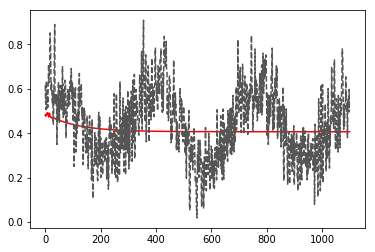

In [14]:
pred = model.predict(start=len(train), end=len(train)+len(test))
plot(pred, color='red')
plot(test, linestyle="--", color="#555555")

Forecast를 해주기 위해서 따로 함수를 만들었습니다.<br>
언뜻보면 매우 잘 돌아가는 것 처럼 보이지만, Autoregressive Model은 예측된 값으로 다시 예측을 하는 것이 아니라 t+1 의 값을 예측한뒤, t+1에는 실제값을 lags에 넣어서 다시 그 다음 t+2를 예측 합니다. 
즉 Autoregressive Model자체가 t+1 이상의 예측을 제대로 해낼수 없음을 말합니다.

prediction shape: (1100,)
test shape      : (1100, 1)
R^2 Score: 0.501666079791


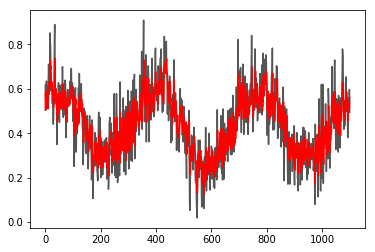

In [52]:
def forecast(model, data, n, real=False):
    window = model.k_ar
    c = model.params[0]
    coefs = model.params[1:]
    
    lags = data[-window:].reshape(-1)
    preds = list()
    
    for i in range(n):
        lags = lags[-window:]
        
        next_v = np.sum(lags[::-1] * coefs) + c
        if real:
            lags = np.append(lags, next_v) # 예측된 값 자체를 lags로 집어 넣는다. 
        else:
            lags = np.append(lags, data[i]) # true데이터를 lags로 집어 넣는다.
        preds.append(next_v)
        
    return np.array(preds)
    
    
pred = forecast(model, test, n=len(test), real=False)
print('prediction shape:', pred.shape)
print('test shape      :', test.shape)
print('R^2 Score:', r2_score(pred, test))
plot(test, color='#555555')
plot(pred, color='red')

예측된 값으로 다시 예측을 시도할시.. 예측률이 -46까지 떨어집니다.

prediction shape: (1100,)
test shape      : (1100, 1)
R^2 Score: -46.7334503816


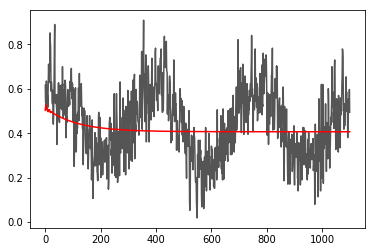

In [48]:
pred = forecast(model, test, n=len(test), real=True)
print('prediction shape:', pred.shape)
print('test shape      :', test.shape)
print('R^2 Score:', r2_score(pred, test))
plot(test, color='#555555')
plot(pred, color='red')

정말로 예측을 t+1밖에 못하는것인지.. 구현이 동일한지 확인을 하였습니다. <br>
결과적으로 r^2 score가 1값이 나오면서 제가 만든 구현이 라이브러리에서 제공하는 것과 동일하며, Autoregressive Model은 t+1밖에 forecast를 못합니다. 즉.. 못한다는 뜻은 예측값으로 다시 예측을 하는 것이 아니라, t+1을 예측후, t+1 = 실제값 을 넣어서 다시 예측을 하기 때문에 진정한 의미의 forecast를 하는것은 아닙니다.

R^2 Score: 1.0


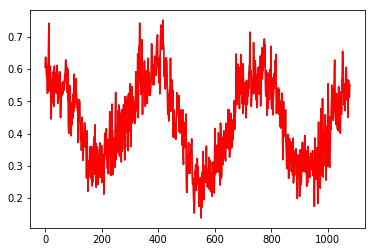

In [78]:
model2 = AR(test)
model2 = model2.fit(disp=True)
pred1 = model2.predict(start=model2.k_ar, end=len(test)+model2.k_ar-1)
pred2 = forecast(model2, test, n=len(test), real=False)

# 내가 만든 forecast와 predict의 구현 차이가 조금 있다. 하지만 결과는 동일하다
pred1 = pred1[:-model2.k_ar]
pred2 = pred2[model2.k_ar:]

print('R^2 Score:', r2_score(pred1, pred2))
plot(pred1, color="#555555")
plot(pred2, color='red')

# Auto-Regressive Integrated Moving Average (ARIMA)

ARIMA를 적용하기 위해서는 time series는 linear 하며 통계적 분포(normal distribution같은 statistical distribution)을 따른다고 가정합니다. <br>
다음의 모델들의 특징을 모두 갖고 있습니다.

* Autoregressive (AR)
* Moving Average (MA)

# References 

* http://users.dma.unipi.it/~flandoli/AUTCap4.pdf
* https://gejza.nipax.cz/_media/stochasticke_procesy:1302.6613.pdf
* https://onlinecourses.science.psu.edu/stat510/
* http://homepage.stat.uiowa.edu/~rdecook/stat2020/notes/ch5_pt1.pdf